In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## Data reading and preprocessing

In [2]:
train = pd.read_csv('/kaggle/input/ner-data/ner.csv')

In [3]:
import pandas as pd
from tqdm import tqdm

# Assuming df is your DataFrame and it has columns 'text' and 'labels'
df = train.copy()

# Split the text and labels into lists of words
df['text'] = df['text'].apply(lambda x: x.split())
df['labels'] = df['labels'].apply(lambda x: x.split())

# Create a new DataFrame to hold the results
result = pd.DataFrame()

# Iterate over the rows of the original DataFrame
for i, row in tqdm(df.iterrows()):
    # Create a new DataFrame for the current sentence
    if len(row['text']) != len(row['labels']):
        continue
    sentence = pd.DataFrame({
        'sentence_id': [i] * len(row['text']),
        'entity_id': [j for j in range(len(row['text']))],
        'entity': row['text'],
        'tag': row['labels']
    })

    # Append the sentence to the result DataFrame
    result = pd.concat([result, sentence], ignore_index=True)

# Print the result
print(result)


47959it [16:04, 49.70it/s] 

         sentence_id  entity_id         entity tag
0                  0          0      Thousands   O
1                  0          1             of   O
2                  0          2  demonstrators   O
3                  0          3           have   O
4                  0          4        marched   O
...              ...        ...            ...  ..
1048168        47958         27         weight   O
1048169        47958         28             in   O
1048170        47958         29           gold   O
1048171        47958         30              .   O
1048172        47958         31              "   O

[1048173 rows x 4 columns]


In [4]:
train.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [5]:
result.head()

,sentence_id,entity_id,entity,tag
0,0,0,Thousands,O
1,0,1,of,O
2,0,2,demonstrators,O
3,0,3,have,O
4,0,4,marched,O


In [6]:
train = result

First, let's divide dataset on train and validation. And split the dataframe according to random split.

In [7]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.2
train_split, val_split = train_test_split(range(train['sentence_id'].max()), test_size=VALIDATION_RATIO, random_state=420)

And then split the original dataframe by ids that we splitted.

In [8]:
train_dataframe = train[train['sentence_id'].isin(train_split)]
val_dataframe = train[train['sentence_id'].isin(val_split)]

In [9]:
pos_tags = train['tag'].unique().tolist() + ['PAD']
cat2idx = {tag: i for i, tag in enumerate(pos_tags)}
idx2cat = {v: k for k, v in cat2idx.items()}

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

For working with datasets more efficiently, let's create separate classes for datasets. 



In [10]:
!pip install torchtext==0.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 1.12.0 which is incompatible.
stable-baselines3 2.1.0 requires torch>=1.13, but you have torch 1.12.0 which is incompatible.


In [11]:
import torch
torch.manual_seed(420)
from torchtext.vocab import build_vocab_from_iterator


class PosTaggingDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, vocab=None, max_size=100):
        self.dataframe = dataframe
        self._preprocess()
        self.vocab = vocab or self._create_vocab()

    def _preprocess(self):
        # fill missing values in entities
        self.dataframe['entity'].fillna(" ", inplace = True)

        # Fill missing tag to `other` - `O`
        self.dataframe['tag'].fillna("O", inplace = True)

        # Clean entities column
        self.dataframe['entity'] = self.dataframe['entity'].apply(lambda x: x.lower() if isinstance(x, str) else x)
        
        # Split the dataset, so that we will have 
        # full sentences and full tags by the same index
        sent_tags = self.dataframe.sort_values(['sentence_id', 'entity_id']).groupby('sentence_id')
        self.sentences = sent_tags['entity'].apply(list).to_list()
        self.tags = sent_tags['tag'].apply(list).to_list()
    
    def _create_vocab(self):
        # creates vocabulary that is used for encoding 
        # the sequence of tokens (splitted sentence)
        def yeild_tokens(df):
            for row in df:
                yield row
        
        vocab = build_vocab_from_iterator(yeild_tokens(self.sentences), specials=special_symbols)
        vocab.set_default_index(UNK_IDX)
        return vocab

    def _get_sentence(self, index: int) -> list:
        # retrieves sentence from dataset by index
        sent = self.sentences[index]
        return self.vocab(sent)

    def _get_labels(self, index: int) -> list:
        # retrieves tags from dataset by index
        tags = [cat2idx[i] for i in self.tags[index]]
        return tags

    def __getitem__(self, index) -> tuple[list, list]:
        return self._get_sentence(index), self._get_labels(index)
    
    def __len__(self) -> int:
        return len(self.sentences)

In [12]:
# Create train dataset
train_dataset = PosTaggingDataset(train_dataframe)
val_dataset = PosTaggingDataset(val_dataframe, vocab=train_dataset.vocab)

And now we are able to create dataloader faster, because we created torch datasets

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
max_size = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def collate_batch(batch: list):
    # Collate list of samples into tensor batch
    # As an input we have list of pair from dataset:
    # [([ent1, ent2, ...], [tag1, tag2, ...]), ([ent1, ent2, ...], [tag1, tag2, ...]), ...]
    # as an output, we want to have tensor of entities and tensor of tags 
    sentences_batch, postags_batch = [], []
    current_sent, current_tags = [], []
    for _sent, _postags in batch:
        for ent, tag in zip(_sent, _postags):
            current_sent.append(ent)
            current_tags.append(tag)
            if len(current_sent) == max_size:
                break
        while len(current_sent) < max_size:
            current_sent.append(PAD_IDX)
            current_tags.append(cat2idx['PAD'])
        sentences_batch.append(torch.Tensor(current_sent))
        postags_batch.append(torch.Tensor(current_tags))
        current_sent, current_tags = [], []
        

    # Remember, that if we want to perform many to many mapping with our network with recurrent units, 
    # we want pass first item from all sequences as first input, thus
    # we want to have tensor with shape (max_size, ...., batch_size)
    sentences_tensor = torch.stack(sentences_batch, dim=0).int().T.to(device)
    postags_tensor = torch.stack(postags_batch, dim=0).T.long().to(device)
    return sentences_tensor, postags_tensor

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [14]:
# just to check that all shapes are correct

for batch in train_dataloader:
    inp, out = batch
    print(inp.shape)
    print(out.shape)
    break

torch.Size([50, 128])
torch.Size([50, 128])


## Creating the network

For the many-to-many or seq2seq netoworks, we want to have recurrent units in the network. This gives the ability for network to learn the hidden features and pass the knowledge from one token to other. 

### Embeddings

For embeddings you can use `nn.Embedding` for creating your own features or use pretrained embedding (like GloVe or FastText or Bert).

### Recurrent

For processing sequences you can use recurrent units like `LSTM`.

### Linear

Add simple nn.Linear. ~~This is basic stuff what do you want~~

### Regularization

Remeber to set up Dropout and Batch Normalization for regularization purposes.

In [15]:
import torch
import torch.nn as nn

class POSTagger(nn.Module):
    def __init__(self, input_dim, output_dim, pad_idx, embed_dim=200, hidden_dim=256, dropout=0.2):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        

    def forward(self, text):
        # text shape= [sent len, batch size]
        x = self.embedding(text)
        x = self.dropout(x)
        x, _ = self.lstm(x)
        predictions = self.linear(x)
        # predictions shape = [sent len, batch size, output dim]

        return predictions

## Training

As for training you should take into account that the shape of your output and shape of the labels. Perform required transformations and use loss function that fits your task.

> Do not forget about tqdm and logging, you want normal training not some unreadable ~~sht~~ logs. 

In [19]:
from tqdm.autonotebook import tqdm

def train_one_epoch(
    model,
    loader,
    optimizer,
    loss_fn
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    model.train()
    train_loss = 0.0
    total_samples = 0
    for i, batch in loop:
        texts, labels = batch

        optimizer.zero_grad()
        outputs = model(texts)
        outputs = outputs.transpose(1, 2)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(labels)
        total_samples += len(labels)

        loop.set_postfix({"loss": train_loss/total_samples})
    return train_loss

def val_one_epoch(
    model,
    loader,
    loss_fn,
    best_so_far=0.0,
    ckpt_path='best.pt'
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    val_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0
    total_not_pad = 0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for i, batch in loop:
            texts, labels = batch

            outputs = model(texts)
            outputs = outputs.transpose(1, 2)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += len(labels)
            not_pad = (labels != cat2idx['PAD']).nonzero(as_tuple=True)[0]
            labels = labels[not_pad]
            predicted = predicted[not_pad]
            correct_predictions += (predicted == labels).sum().item()
            total_not_pad += len(not_pad)
            val_loss += loss.item() * len(labels)
            loop.set_postfix({"loss": val_loss/total_samples, "acc": correct_predictions / total_not_pad})

        if correct_predictions / total_not_pad > best_so_far:
            torch.save(model.state_dict(), "best.pt")
            return correct_predictions / total_not_pad

    return best_so_far

In [31]:
from torch.optim import Adam

INPUT_DIM = len(train_dataset.vocab)
OUTPUT_DIM = len(pos_tags)

model = POSTagger(INPUT_DIM, OUTPUT_DIM, PAD_IDX).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=cat2idx['PAD'])

Epoch 1: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 16: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20: val:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 21: train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21: val:   0%|          | 0/75 [00:00<?, ?it/s]

Early stopping after 10 epochs without improvement.


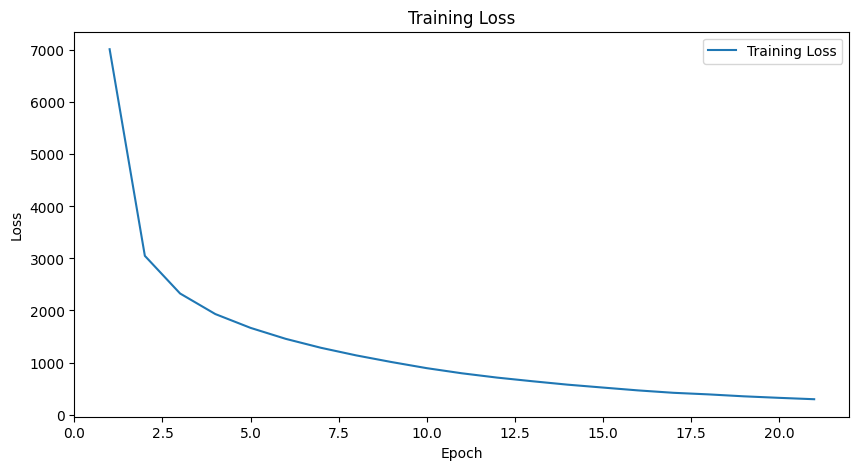

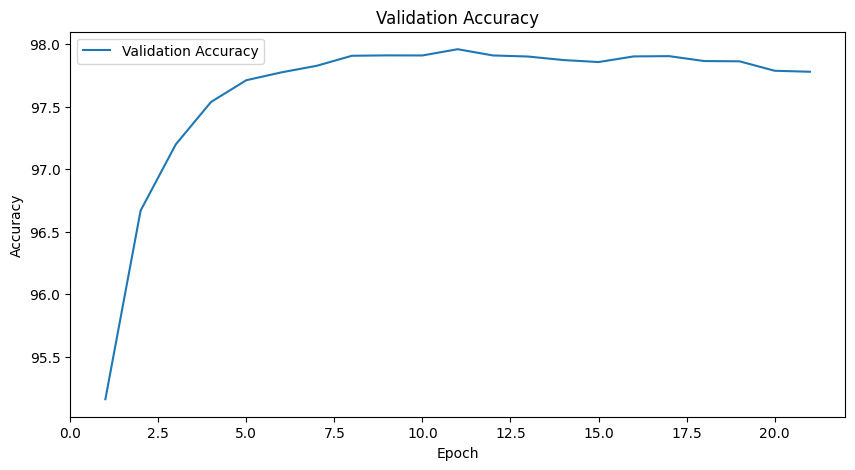

In [32]:
import matplotlib.pyplot as plt

best = -float('inf')
patience = 10
delta = 0.0001
ckpt_path='best.pt'

best_so_far = -float('inf')
early_stop_counter = 0
epoch = 0

# Lists to store loss and accuracy values
train_losses = []
val_accs = []

while True:
    epoch += 1
    train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn)
    val_acc = val_one_epoch(model, val_dataloader, loss_fn)

    # Append loss and accuracy values to the lists
    train_losses.append(train_loss)
    val_accs.append(val_acc)

    if val_acc > best_so_far + delta:
        best_so_far = val_acc
        torch.save(model.state_dict(), ckpt_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
